# Beating a Random Walker in a Competition

The goal of this notebook is to develop a strategy to beat a random walk in a competition by the largest possible margin.

## Background

A "competition" $C$ consists of the following:
- A graph $G$ consisting of vertices $V$ and edges $E$. For our purposes, we take $V = [n]$ for some size $n$ and undirected edges $E \subseteq V^2$.
- Two "walkers" $W_1$ and $W_2$:
    - Each walker is in essence a function $V \to V$, dictating the next move the walker will take at each step. This function is not necessarily deterministic, especially in the case of a random walk.
    - The starting node for each walker is determined by their respective 
    
When a walker reaches a vertex that has been unvisited, it "captures" the vertex. Let $S_{1, t}$ be the number of vertices captured by $W_1$ at step $t$, and $S_{2, t}$ be the number of vertices captured by $W_2$ at step $t$. We measure the relative performance of walker 1 vs. walker 2 at step $t$ as $P_t := \frac{S_{1, t}}{S_{2, t}}$.

In [39]:
# Setup

%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

sys.path.insert(0, '..')
plt.rcParams['figure.figsize'] = [10, 8]

import walkers
from graph import Graph

In [2]:
def simulate_competition(graph, walker1, walker2):
    steps = 10*len(graph)
    walker1.load_graph(graph)
    walker2.load_graph(graph)
    
    # track who has captured what
    walker1_captured = set()
    walker2_captured = set()
    
    # if they start at the same place, randomly choose who captures
    if walker1.cur == walker2.cur:
        if random.choice([True, False]):
            walker1_captured.add(walker1.cur)
        else:
            walker2_captured.add(walker2.cur)
    else:
        walker1_captured.add(walker1.cur)
        walker2_captured.add(walker2.cur)
        
    S1 = np.zeros(steps+1)
    S2 = np.zeros(steps+1)
    P = np.zeros(steps+1)
    
    S1[0] = len(walker1_captured)
    S2[0] = len(walker2_captured)
    P[0] = S1[-1]/S2[-1] if S2[-1] != 0 else np.nan
    
    for i in range(1, steps+1):
        walker1.move()
        walker2.move()
        
        # if walkers end up at same unvisited spot, decided randomly who captures
        if walker1.cur == walker2.cur and \
            walker1.cur not in walker1_captured.union(walker2_captured):
                if random.choice([True, False]):
                    walker1_captured.add(walker1.cur)
                else:
                    walker2_captured.add(walker2.cur)
        else:
            if walker1.cur not in walker2_captured:
                walker1_captured.add(walker1.cur)
            if walker2.cur not in walker1_captured:
                walker2_captured.add(walker2.cur)
                
        S1[i] = len(walker1_captured)
        S2[i] = len(walker2_captured)
        P[i] = S1[i]/S2[i]
    
    results = {
        "S1": S1,
        "S2": S2,
        "P": P
    }
    
    return results

## Random Walker vs Random Walker on Random Graph

It is expected that when $G$ is an ER random graph and we have two random walkers starting at random nodes, then $P_t \approx 1$ at all $t$, and $S_t \to 0.5$. 

Let's take $n = 1000$, $d = 10$, $p = \frac{d}{n}$, and run $k = 1000$ competition simulations.

In [3]:
# Parameters
n = 1000
d = 10
p = d/n
k = 1000

In [4]:
P_avg = None

for _ in range(k):
    graph = Graph.get_er_random_graph(n, p)
    
    walker1 = walkers.RandomWalker()
    walker2 = walkers.RandomWalker()
    
    results = simulate_competition(graph, walker1, walker2)
    
    if P_avg is None:
        P_avg = results["P"]
    else:
        P_avg += results["P"]
P_avg /= k

In [5]:
np.savetxt("rw_vs_rw_rg.csv", P_avg, delimiter=",")

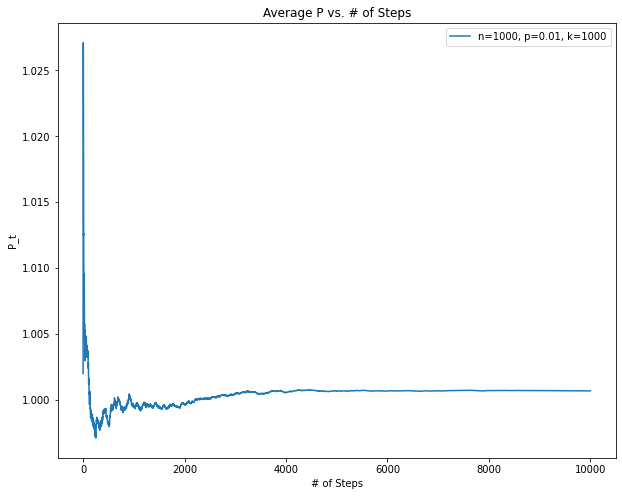

In [6]:
plt.plot(np.arange(0, len(P_avg), step=1), P_avg, label=f"n={n}, p={p}, k={k}")
plt.title("Average P vs. # of Steps")
plt.xlabel("# of Steps")
plt.ylabel("P_t")
plt.legend()
plt.show()

We can see that over the course of the competition, on average $P_t \approx 1$, indicating roughly equal performance in both random walkers.

## Greedy Unbiased Walker vs Random Walker

The strategy of the greedy unbiased walker is similar to the random walker, except it will not travel to previously-visited nodes unless it is the only option. This strategy should clearly outperform the random walk since independently, it will visit duplicate nodes at a far lower frequency.

In [7]:
P_avg = None

for _ in range(k):
    graph = Graph.get_er_random_graph(n, p)
    
    walker1 = walkers.GreedyUnbiasedWalker()
    walker2 = walkers.RandomWalker()
    
    results = simulate_competition(graph, walker1, walker2)
    
    if P_avg is None:
        P_avg = results["P"]
    else:
        P_avg += results["P"]
P_avg /= k

In [8]:
np.savetxt("guw_vs_rw_rg.csv", P_avg, delimiter=",")

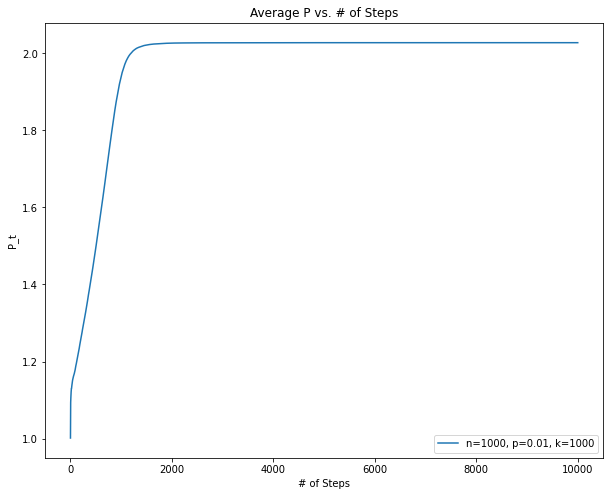

In [9]:
plt.plot(np.arange(0, len(P_avg), step=1), P_avg, label=f"n={n}, p={p}, k={k}")
plt.title("Average P vs. # of Steps")
plt.xlabel("# of Steps")
plt.ylabel("P_t")
plt.legend()
plt.show()

In [11]:
P_avg[-1]

2.027402748199417

We can see that at the end of the competition, the greedy unbiased walker captures twice as many nodes as the random walker on average. But can we do better?

## Genetic Algorithms to Beat the Random Walk

Genetic algorithms are machine learning algorithms that attempt to replicate the process of natural selection to find an agent with the highest "fitness". 

### GA in non-competitive environment

We test the potential of a genetic algorithm in the scenario without a second walker to compete against. Initialy, we simplify our competition scenario as follows:
- Our graph $G$ is no longer random, but rather the lattice grid $[n] \times [n] \subseteq \mathbb{Z}^2$. Therefore, at each node, you can either traverse up, left, down, or right (wrap-around will occur at the borders).
- Our strategy $W_1$ starts at a random point.

We use a genetic algorithm to train a neural network. The input consists of our current position and parameters indicating which nodes we have captured for a total of $n^2 + 2$ inputs. We will use two hidden layers of size $n^2$ with the ReLU activation function, and have four output nodes with the softmax activation function, representing the four actions we can take (up, left, down, right).

Our fitness function will be the proportion of captured nodes by the walker over n*n steps. In theory, the walker should never revisit a node, so we want the fitness to be 1.

We will take a relatively small $n = 10$ for demonstration.

In [2]:
# Import ML libraries

import torch
import pygad
import pygad.torchga

In [3]:
# Create NN model architecture
n = 10

walker = torch.nn.Sequential(
    torch.nn.Linear(n*n+2, n*n),
    torch.nn.ReLU(),
    torch.nn.Linear(n*n, n*n),
    torch.nn.ReLU(),
    torch.nn.Linear(n*n, 4)
)

In [39]:
# Create fitness function

def fitness_func(solution, idx):
    cur_x = random.randint(0, n-1)
    cur_y = random.randint(0, n-1)
    
    X = torch.zeros(n*n + 2)
    X[-1] = cur_x
    X[-2] = cur_y
    X[cur_y*n + cur_x] = 1
    
    visited = {(cur_x, cur_y)}
    
    steps = n*n
    for _ in range(steps):
        direction = torch.argmax(pygad.torchga.predict(model=walker,
                                        solution=solution,
                                        data=X)).item()
        if direction == 0:
            cur_y = (cur_y + 1) % n
        elif direction == 1:
            cur_y = (cur_y - 1) % n
        elif direction == 2:
            cur_x = (cur_x + 1) % n
        else:
            cur_x = (cur_x - 1) % n

        X[cur_y*n + cur_x]  = 1
        X[-1] = cur_x
        X[-2] = cur_y
        
        visited.add((cur_x, cur_y))
        
    return len(visited)/(n*n)

In [40]:
# Initialize genetic algorithm parameters
torch_ga = pygad.torchga.TorchGA(model=walker, num_solutions=50)

def callback_generation(ga_instance):
    generation_num = ga_instance.generations_completed
    if generation_num == 1 or generation_num % 50 == 0:
        print("Generation {generation}".format(generation=generation_num), end=" ——— ")
        print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))

num_generations = 1000
num_parents_mating = 10
initial_population = torch_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

In [41]:
# Run genetic algorithm
ga_instance.run()

Generation 1 ——— Fitness = 0.38
Generation 50 ——— Fitness = 0.68
Generation 100 ——— Fitness = 0.68
Generation 150 ——— Fitness = 0.69
Generation 200 ——— Fitness = 0.71
Generation 250 ——— Fitness = 0.73
Generation 300 ——— Fitness = 0.73
Generation 350 ——— Fitness = 0.73
Generation 400 ——— Fitness = 0.73
Generation 450 ——— Fitness = 0.74
Generation 500 ——— Fitness = 0.74
Generation 550 ——— Fitness = 0.74
Generation 600 ——— Fitness = 0.74
Generation 650 ——— Fitness = 0.74
Generation 700 ——— Fitness = 0.74
Generation 750 ——— Fitness = 0.74
Generation 800 ——— Fitness = 0.74
Generation 850 ——— Fitness = 0.74
Generation 900 ——— Fitness = 0.74
Generation 950 ——— Fitness = 0.74
Generation 1000 ——— Fitness = 0.74


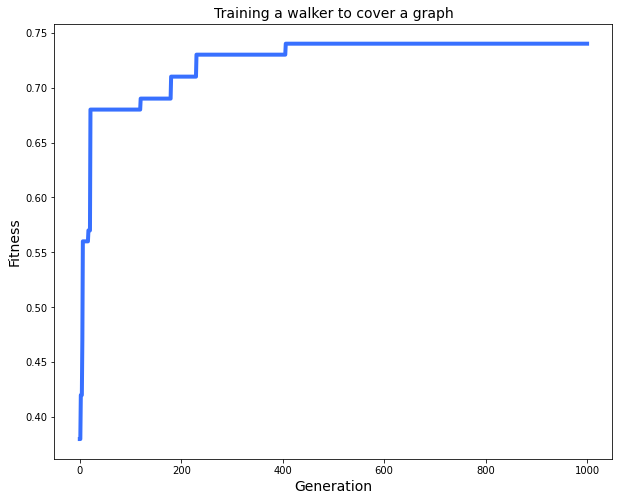

Fitness value of the best solution = 0.74


In [61]:
ga_instance.plot_fitness(title="Training a walker to cover a graph", linewidth=4)
# Returning the details of the best solution.
solution_best, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

In [46]:
# Save the model
import pickle
with open('nn_walker_v1.pkl', 'wb') as outp:
    pickle.dump(solution, outp, pickle.HIGHEST_PROTOCOL)

How does this model, compare to the random walk?

In [66]:
def simulate_rw_lattice():
    cur_x = random.randint(0, n-1)
    cur_y = random.randint(0, n-1)
    
    visited = {(cur_x, cur_y)}
    
    steps = n*n
    for _ in range(steps):
        direction = random.choice([0, 1, 2, 3])
        if direction == 0:
            cur_y = (cur_y + 1) % n
        elif direction == 1:
            cur_y = (cur_y - 1) % n
        elif direction == 2:
            cur_x = (cur_x + 1) % n
        else:
            cur_x = (cur_x - 1) % n
        
        visited.add((cur_x, cur_y))
        
    return len(visited)/(n*n)

In [71]:
avg_rw_fitness = 0
k=10000
for _ in range(k):
    avg_rw_fitness += simulate_rw_lattice()
avg_rw_fitness /= k

In [72]:
avg_rw_fitness

0.4582099999999955

These results are promising, and motivate the possible use of neural networks in developing a strategy to beat a random walk in a competition.

## Training a walker in competition with GA

We try a more complex NN architecture for competition. We will also use $n = 10$ in our competition, and run it for $2n^2$ steps. We also give our model the position of the RW and what vertices the RW has covered.

In [120]:
# Import ML libraries

import torch
import pygad
import random
import pygad.torchga

In [121]:
# Create NN model architecture
n = 10

n_x = 2*n*n+4

walker = torch.nn.Sequential(
    torch.nn.Linear(n_x, n_x),
    torch.nn.ReLU(),
    torch.nn.Linear(n_x, n_x//2),
    torch.nn.ReLU(),
    torch.nn.Linear(n_x//2, 4),
    torch.nn.Softmax(dim=0)
)

In [122]:
# Create fitness function

def fitness_func(solution, idx):
    walker1_cur = (random.randint(0, n-1), random.randint(0, n-1))
    walker2_cur = (random.randint(0, n-1), random.randint(0, n-1))
        
    X = torch.zeros(n_x)
    X[-1] = walker1_cur[0]
    X[-2] = walker1_cur[1]
    X[-3] = walker2_cur[0]
    X[-4] = walker2_cur[1]
    X[walker1_cur[1]*n + walker1_cur[0]] = 1
    X[n*n + walker2_cur[1]*n + walker2_cur[0]] = 1
    
    # track who has captured what
    walker1_captured = set()
    walker2_captured = set()
    
    # if they start at the same place, randomly choose who captures
    if walker1_cur == walker2_cur:
        if random.choice([True, False]):
            walker1_captured.add(walker1_cur)
        else:
            walker2_captured.add(walker2_cur)
    else:
        walker1_captured.add(walker1_cur)
        walker2_captured.add(walker2_cur)

    steps = 2*n*n
    while len(walker1_captured) + len(walker2_captured) < n*n:
        direction_prob = pygad.torchga.predict(model=walker,
                                        solution=solution,
                                        data=X)

        direction1 = random.choices([0, 1, 2, 3], weights=direction_prob.tolist(), k=1)[0]
        direction2 = random.choice([0, 1, 2, 3])

        cur_x1 = walker1_cur[0]
        cur_y1 = walker1_cur[1]
        cur_x2 = walker2_cur[0]
        cur_y2 = walker2_cur[1]
    
        if direction1 == 0:
            cur_y1 = (cur_y1 + 1) % n
        elif direction1 == 1:
            cur_y1 = (cur_y1 - 1) % n
        elif direction1 == 2:
            cur_x1 = (cur_x1 + 1) % n
        else:
            cur_x1 = (cur_x1 - 1) % n
            
        if direction2 == 0:
            cur_y2 = (cur_y2 + 1) % n
        elif direction2 == 1:
            cur_y2 = (cur_y2 - 1) % n
        elif direction2 == 2:
            cur_x2 = (cur_x2 + 1) % n
        else:
            cur_x2 = (cur_x2 - 1) % n

        walker1_cur = (cur_x1, cur_y1)
        walker2_cur = (cur_x2, cur_y2)
        
        X[-1] = walker1_cur[0]
        X[-2] = walker1_cur[1]
        X[-3] = walker2_cur[0]
        X[-4] = walker2_cur[1]
        X[walker1_cur[1]*n + walker1_cur[0]] = 1
        X[n*n + walker2_cur[1]*n + walker2_cur[0]] = 1
        
        # if walkers end up at same unvisited spot, decided randomly who captures
        if walker1_cur == walker2_cur and \
            walker1_cur not in walker1_captured.union(walker2_captured):
                if random.choice([True, False]):
                    walker1_captured.add(walker1_cur)
                else:
                    walker2_captured.add(walker2_cur)
        else:
            if walker1_cur not in walker2_captured:
                walker1_captured.add(walker1_cur)
            if walker2_cur not in walker1_captured:
                walker2_captured.add(walker2_cur)
        
    return len(walker1_captured)/len(walker2_captured) if len(walker2_captured) != 0 else 10**9

In [123]:
# Initialize genetic algorithm parameters
torch_ga = pygad.torchga.TorchGA(model=walker, num_solutions=100)

def callback_generation(ga_instance):
    generation_num = ga_instance.generations_completed
    print("Generation {generation}".format(generation=generation_num), end=" ——— ")
    print("Best Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))

num_generations = 1000
num_parents_mating = 5
initial_population = torch_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

In [124]:
# Run genetic algorithm
ga_instance.run()

Generation 1 ——— Best Fitness = 1.631578947368421
Generation 2 ——— Best Fitness = 2.125
Generation 3 ——— Best Fitness = 2.125
Generation 4 ——— Best Fitness = 2.125
Generation 5 ——— Best Fitness = 2.125
Generation 6 ——— Best Fitness = 2.125
Generation 7 ——— Best Fitness = 2.125
Generation 8 ——— Best Fitness = 2.125
Generation 9 ——— Best Fitness = 2.125
Generation 10 ——— Best Fitness = 2.125
Generation 11 ——— Best Fitness = 2.125
Generation 12 ——— Best Fitness = 2.7037037037037037
Generation 13 ——— Best Fitness = 2.7037037037037037
Generation 14 ——— Best Fitness = 2.7037037037037037
Generation 15 ——— Best Fitness = 2.7037037037037037
Generation 16 ——— Best Fitness = 2.7037037037037037
Generation 17 ——— Best Fitness = 2.7037037037037037
Generation 18 ——— Best Fitness = 2.7037037037037037
Generation 19 ——— Best Fitness = 2.7037037037037037
Generation 20 ——— Best Fitness = 2.7037037037037037
Generation 21 ——— Best Fitness = 2.7037037037037037
Generation 22 ——— Best Fitness = 2.7037037037037

Generation 161 ——— Best Fitness = 3.5454545454545454
Generation 162 ——— Best Fitness = 3.5454545454545454
Generation 163 ——— Best Fitness = 3.5454545454545454
Generation 164 ——— Best Fitness = 3.5454545454545454
Generation 165 ——— Best Fitness = 3.5454545454545454
Generation 166 ——— Best Fitness = 3.5454545454545454
Generation 167 ——— Best Fitness = 3.5454545454545454
Generation 168 ——— Best Fitness = 3.5454545454545454
Generation 169 ——— Best Fitness = 3.5454545454545454
Generation 170 ——— Best Fitness = 3.5454545454545454
Generation 171 ——— Best Fitness = 3.5454545454545454
Generation 172 ——— Best Fitness = 3.5454545454545454
Generation 173 ——— Best Fitness = 3.5454545454545454
Generation 174 ——— Best Fitness = 3.5454545454545454
Generation 175 ——— Best Fitness = 3.5454545454545454
Generation 176 ——— Best Fitness = 3.5454545454545454
Generation 177 ——— Best Fitness = 3.5454545454545454
Generation 178 ——— Best Fitness = 3.5454545454545454
Generation 179 ——— Best Fitness = 3.5454545454

Generation 316 ——— Best Fitness = 3.5454545454545454
Generation 317 ——— Best Fitness = 3.5454545454545454
Generation 318 ——— Best Fitness = 4.0
Generation 319 ——— Best Fitness = 4.0
Generation 320 ——— Best Fitness = 4.0
Generation 321 ——— Best Fitness = 4.0
Generation 322 ——— Best Fitness = 4.0
Generation 323 ——— Best Fitness = 4.0
Generation 324 ——— Best Fitness = 4.0
Generation 325 ——— Best Fitness = 4.0
Generation 326 ——— Best Fitness = 4.0
Generation 327 ——— Best Fitness = 4.0
Generation 328 ——— Best Fitness = 4.0
Generation 329 ——— Best Fitness = 4.0
Generation 330 ——— Best Fitness = 4.0
Generation 331 ——— Best Fitness = 4.0
Generation 332 ——— Best Fitness = 4.0
Generation 333 ——— Best Fitness = 4.0
Generation 334 ——— Best Fitness = 4.0
Generation 335 ——— Best Fitness = 4.0
Generation 336 ——— Best Fitness = 4.0
Generation 337 ——— Best Fitness = 4.0
Generation 338 ——— Best Fitness = 4.0
Generation 339 ——— Best Fitness = 4.0
Generation 340 ——— Best Fitness = 4.0
Generation 341 ——— B

Generation 531 ——— Best Fitness = 4.0
Generation 532 ——— Best Fitness = 4.0
Generation 533 ——— Best Fitness = 4.0
Generation 534 ——— Best Fitness = 4.0
Generation 535 ——— Best Fitness = 4.0
Generation 536 ——— Best Fitness = 4.0
Generation 537 ——— Best Fitness = 4.0
Generation 538 ——— Best Fitness = 4.0
Generation 539 ——— Best Fitness = 4.0
Generation 540 ——— Best Fitness = 4.0
Generation 541 ——— Best Fitness = 4.0
Generation 542 ——— Best Fitness = 4.0
Generation 543 ——— Best Fitness = 4.0
Generation 544 ——— Best Fitness = 4.0
Generation 545 ——— Best Fitness = 4.0
Generation 546 ——— Best Fitness = 4.0
Generation 547 ——— Best Fitness = 4.0
Generation 548 ——— Best Fitness = 4.0
Generation 549 ——— Best Fitness = 4.0
Generation 550 ——— Best Fitness = 4.0
Generation 551 ——— Best Fitness = 4.0
Generation 552 ——— Best Fitness = 4.0
Generation 553 ——— Best Fitness = 4.0
Generation 554 ——— Best Fitness = 4.0
Generation 555 ——— Best Fitness = 4.0
Generation 556 ——— Best Fitness = 4.0
Generation 5

Generation 747 ——— Best Fitness = 4.0
Generation 748 ——— Best Fitness = 4.0
Generation 749 ——— Best Fitness = 4.0
Generation 750 ——— Best Fitness = 4.0
Generation 751 ——— Best Fitness = 4.0
Generation 752 ——— Best Fitness = 4.0
Generation 753 ——— Best Fitness = 4.0
Generation 754 ——— Best Fitness = 4.0
Generation 755 ——— Best Fitness = 4.0
Generation 756 ——— Best Fitness = 4.0
Generation 757 ——— Best Fitness = 4.0
Generation 758 ——— Best Fitness = 4.0
Generation 759 ——— Best Fitness = 4.0
Generation 760 ——— Best Fitness = 4.0
Generation 761 ——— Best Fitness = 4.0
Generation 762 ——— Best Fitness = 4.0
Generation 763 ——— Best Fitness = 4.0
Generation 764 ——— Best Fitness = 4.0
Generation 765 ——— Best Fitness = 4.0
Generation 766 ——— Best Fitness = 4.0
Generation 767 ——— Best Fitness = 4.0
Generation 768 ——— Best Fitness = 4.0
Generation 769 ——— Best Fitness = 4.0
Generation 770 ——— Best Fitness = 4.0
Generation 771 ——— Best Fitness = 4.0
Generation 772 ——— Best Fitness = 4.0
Generation 7

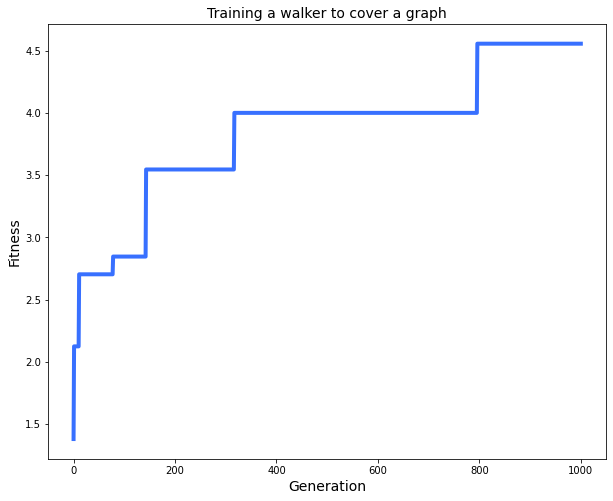

Fitness value of the best solution = 4.555555555555555


In [153]:
ga_instance.plot_fitness(title="Training a walker to cover a graph", linewidth=4)
# Returning the details of the best solution.
solution_best1, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

In [137]:
# Save the model
import pickle
with open('nn_comp_walker_v1.pkl', 'wb') as outp:
    pickle.dump(solution_best, outp, pickle.HIGHEST_PROTOCOL)